In [131]:
import pandas
import numpy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [132]:
df = pandas.read_csv("../../data/raw/churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

categorical_columns = list(df.dtypes[df.dtypes == "object"].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(" ", "_")

df.totalcharges = pandas.to_numeric(df.totalcharges, errors="coerce")
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == "yes").astype(int)
#
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train["churn"]
del df_val["churn"]
del df_test["churn"]
#
numerical = ["tenure", "monthlycharges", "totalcharges"]

categorical = [
    "gender",
    "seniorcitizen",
    "partner",
    "dependents",
    "phoneservice",
    "multiplelines",
    "internetservice",
    "onlinesecurity",
    "onlinebackup",
    "deviceprotection",
    "techsupport",
    "streamingtv",
    "streamingmovies",
    "contract",
    "paperlessbilling",
    "paymentmethod",
]

#
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

#
val_dict = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = y_pred >= 0.5
(y_val == churn_decision).mean()

# Accuracy

the fraction of correct preditions


In [134]:
len(y_val)

1409

In [173]:
(y_val == churn_decision).sum()

np.int64(1023)

In [136]:
# the accuracy
from sklearn.metrics import accuracy_score

print(1132 / 1409)

# or
print((y_val == churn_decision).mean())

# or
accuracy_score(y_val, churn_decision)

0.8034066713981547
0.8034066713981547


0.8034066713981547

0.00 0.274
0.05 0.509
0.10 0.592
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.796
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


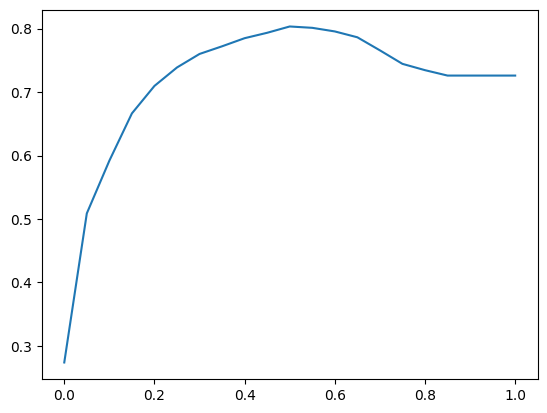

In [137]:
# find the best value of decision cond.
from sklearn.metrics import accuracy_score

thresholds = numpy.linspace(0, 1, 21)
scores = []

for t in thresholds:
    churn_decision = y_pred >= t
    score = accuracy_score(y_val, churn_decision)
    print("%.2f %.3f" % (t, score))
    scores.append(score)

plt.plot(thresholds, scores)
# the best threshold is 0.50 0.803

In [138]:
# dummy model
from collections import Counter

Counter(y_pred >= 1)

Counter({np.False_: 1409})

# Confusion Table

evaluate the quality of the model by different strategies.

When comes to a prediction of an LR model, each falls into one of four different categories:

Prediction is that the customer WILL churn. This is known as the Positive class
And Customer actually churned - Known as a True Positive (TP)
But Customer actually did not churn - Known as a False Positive (FP)
Prediction is that the customer WILL NOT churn' - This is known as the Negative class
Customer did not churn - True Negative (TN)
Customer churned - False Negative (FN)


In [139]:
# people who are going to churn
actual_positive = y_val == 1
# people who are not going to churn
actual_negative = y_val == 0

In [140]:
t = 0.5
predict_positive = y_pred >= t
predict_negative = y_pred < t

In [141]:
predict_positive & actual_positive

tp = (predict_positive & actual_positive).sum()
print(tp)
tn = (predict_negative & actual_negative).sum()
print(tn)

fp = (predict_positive & actual_negative).sum()
print(fp)
fn = (predict_negative & actual_positive).sum()
print(fn)

210
922
101
176


In [142]:
confusion_matrix = numpy.array([[tn, fp], [fn, tp]])

confusion_matrix

array([[922, 101],
       [176, 210]])

In [143]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

# Precision and Recall

(eval. matrix)

Precision : From the predicted positives, how many we predicted right.

Recall : From the real positives, how many we predicted right.


In [144]:
(tp + tn) / (tp + tn + fp + fn)

np.float64(0.8034066713981547)

In [145]:
prec = tp / (tp + fp)
prec

np.float64(0.6752411575562701)

In [146]:
print(tp)
print(tp + fp)

# 210/311
# explain: 67% are correct,33% are mistiks(we pred them to churn but they are not churned)

210
311


In [147]:
recall = tp / (tp + fn)
recall

np.float64(0.5440414507772021)

In [148]:
print(tp)
print(tp + fn)

# 210/386
# explain: 54% are correct,46% are mistiks(we pred them to not churn but they are churned)
# (so the accuracy 80% was misleading)

210
386


# ROC Curves

ROC curves consider Recall and FPR under all the possible thresholds


In [149]:
# tpr:true positive rate
tpr = tp / (tp + fn)
tpr

np.float64(0.5440414507772021)

In [150]:
recall

np.float64(0.5440414507772021)

In [151]:
# fpr: false positive rate
fpr = fp / (fp + tn)
fpr

np.float64(0.09872922776148582)

In [152]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = numpy.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = y_val == 1
        actual_negative = y_val == 0

        predict_positive = y_pred >= t
        predict_negative = y_pred < t

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, tn, fp, fn))

    scores

    columns = ["threshold", "tp", "tn", "fp", "fn"]
    df_scores = pandas.DataFrame(scores, columns=columns)
    return df_scores


df_scores = tpr_fpr_dataframe(y_val, y_pred)
df_scores

,threshold,tp,tn,fp,fn
0,0.00,386,0,1023,0
1,0.01,385,109,914,1
2,0.02,384,193,830,2
3,0.03,383,257,766,3
4,0.04,381,308,715,5
...,...,...,...,...,...
96,0.96,0,1023,0,386
97,0.97,0,1023,0,386
98,0.98,0,1023,0,386
99,0.99,0,1023,0,386


In [153]:
df_scores[::10]

,threshold,tp,tn,fp,fn
0,0.0,386,0,1023,0
10,0.1,366,468,555,20
20,0.2,333,667,356,53
30,0.3,284,787,236,102
40,0.4,249,857,166,137
50,0.5,210,922,101,176
60,0.6,151,970,53,235
70,0.7,76,1003,20,310
80,0.8,13,1022,1,373
90,0.9,0,1023,0,386


In [154]:
df_scores["tpr"] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores["fpr"] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,366,468,555,20,0.948187,0.542522
20,0.2,333,667,356,53,0.862694,0.347996
30,0.3,284,787,236,102,0.735751,0.230694
40,0.4,249,857,166,137,0.645078,0.162268
50,0.5,210,922,101,176,0.544041,0.098729
60,0.6,151,970,53,235,0.391192,0.051808
70,0.7,76,1003,20,310,0.196891,0.019550
80,0.8,13,1022,1,373,0.033679,0.000978
90,0.9,0,1023,0,386,0.000000,0.000000


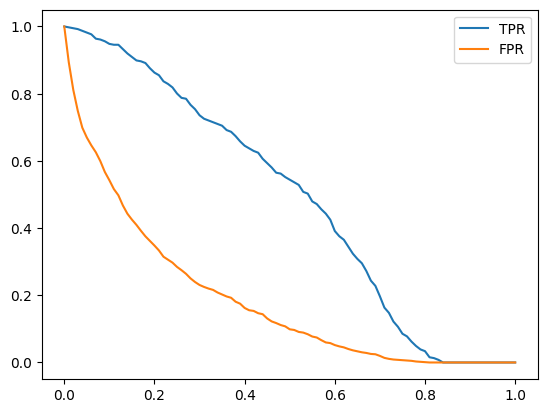

In [155]:
plt.plot(df_scores.threshold, df_scores["tpr"], label="TPR")
plt.plot(df_scores.threshold, df_scores["fpr"], label="FPR")
plt.legend()

# Random model

baseline model


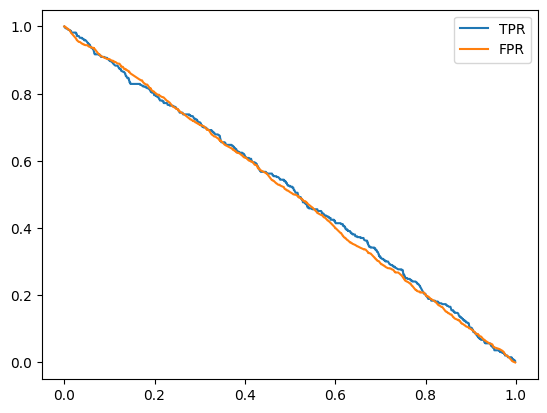

In [177]:
from sklearn.metrics import roc_curve


numpy.random.seed(1)
y_rand = numpy.random.uniform(0, 1, size=len(y_val))
y_rand.round(3)

# Accuracy for our random model is around 50%
((y_rand >= 0.5) == y_val).mean()

random_model_fpr, random_model_tpr, random_model_threshold = roc_curve(y_val, y_rand)

plt.plot(random_model_threshold, random_model_tpr, label="TPR")
plt.plot(random_model_threshold, random_model_fpr, label="FPR")
plt.legend()

Ideal model
(makes correct predictions for every example)

1. order the pred from lowest to highest


In [157]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [158]:
y_ideal = numpy.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1], shape=(1409,))

In [159]:
y_ideal_pred = numpy.linspace(0, 1, len(y_ideal))
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00], shape=(1409,))

In [160]:
y_val.mean()

np.float64(0.2739531582682754)

In [161]:
accuracy_ideal = ((y_ideal_pred >= 0.726) == y_ideal).mean()
accuracy_ideal

np.float64(1.0)

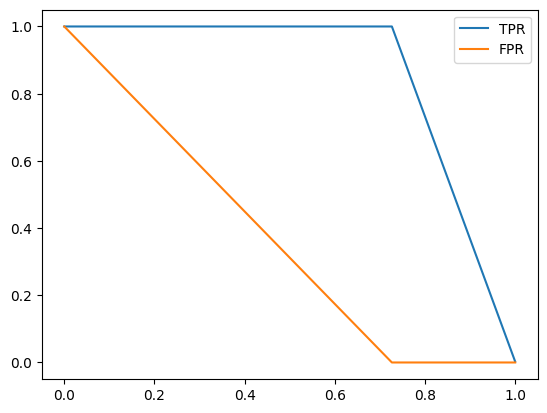

In [162]:
ideal_fpr, ideal_tpr, ideal_threshold = roc_curve(y_ideal, y_ideal_pred)

plt.plot(ideal_threshold, ideal_tpr, label="TPR")
plt.plot(ideal_threshold, ideal_fpr, label="FPR")
plt.legend()

Putting everything together


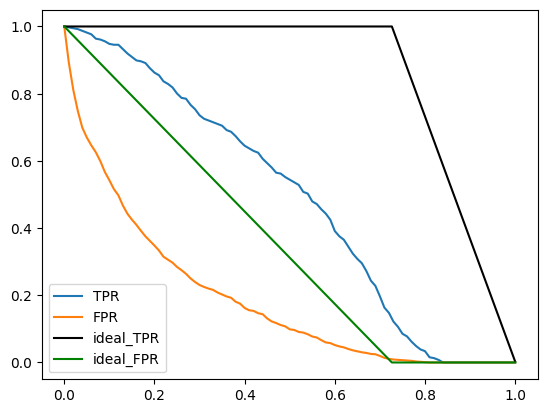

In [ ]:
plt.plot(df_scores.threshold, df_scores["tpr"], label="TPR")
plt.plot(df_scores.threshold, df_scores["fpr"], label="FPR")

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')

plt.plot(ideal_threshold, ideal_tpr, label="ideal_TPR", color="black")
plt.plot(ideal_threshold, ideal_fpr, label="ideal_FPR", color="green")

plt.legend()

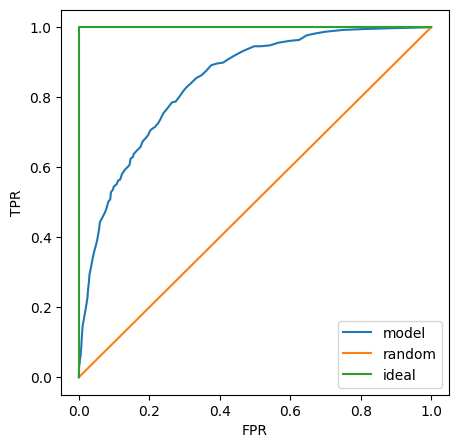

In [ ]:
# the Roc curve
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label="model")
plt.plot([0, 1], [0, 1], label="random")
# plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot(ideal_fpr, ideal_tpr, label="ideal")

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()

# ROC AUC (measure the performance of the model)

(calculate the area under the curve)


In [ ]:
from sklearn.metrics import auc

auc(df_scores.fpr, df_scores.tpr)

0.843899888066694

In [ ]:
auc(ideal_fpr, ideal_tpr)

1.0

In [181]:
# AUC interpretation
# (AUC tells us the probability that a randomly selected positive example has a score that is higher than a randomly selected negative example)

neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

n = 50000

numpy.random.seed(1)
pos_ind = numpy.random.randint(0, len(pos), size=n)
neg_ind = numpy.random.randint(0, len(neg), size=n)
pos[pos_ind] > neg[neg_ind]

(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.84648)

# Cross-Validation